In [193]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from subprocess import STDOUT, check_output
import os
import random
from functools import reduce, partial
from itertools import starmap
from operator import methodcaller, add

In [235]:
def extract_params( filename ):
    ''' Given a string of the form output_wgs%i_%s.out, returns the number encoded
        in %i and the string encoded in %s as a tuple.
    '''
    split = filename.split( '_' )
    if len(split) == 3:
        return split[ 2 ][ : -4 ], int( split[ 1 ][ 3 : ] )
    elif len(split) == 4:
        return split[ 2 ], int( split[ 1 ][ 3 : ] ), float( split[3][ : -4 ] )

def extract_runtime( filepath ):
    
    f = open( filepath, 'r' )
    lines = list( map( lambda s : s.split(), f.readlines() ) )
    cond = lambda l : len(l) == 4 and l[0] == 'Elapsed' and l[1] == 'time:'
    
    try:
        time = float( list( filter( cond, lines ) )[0][2] )
        f.close()
        return time
    except:
        f.close()
    
def process_output_files( folder ):
    
    out_files = [ f for f in os.listdir( folder ) if f[ -3 : ] == 'out' ]
    data = []
    
    for filename in out_files:
        params = extract_params( filename )
        time = extract_runtime( '%s%s' % ( folder, filename ) )
        if time != None:
            data.append( (*params, time) )

    return reduce( lambda x, y : dict( list(x.items()) + [(y[0], tuple(starmap( add, zip( x[y[0]], y[1] ) )))] )
                                 if y[0] in x else
                                 dict( list(x.items()) + [y] ),
                  ((k, tuple([[x] for x in coord])) for k, *coord in data), 
                  dict() )

def runtime_to_speedup( data ):
    basetimes = { '128x128' : 105, '128x256' : 213, '256x256' : 855, '1024x1024' : 3477 }
    return dict( (k, (xs, [ basetimes[k] / t for t in ys ])) 
                 for (k, (xs, ys)) in data.items() )

In [95]:
def plot_scatter( lines, title = '' ):
    
    colors = [ 'red', 'green', 'blue', 'cyan' ]
    fig = plt.figure()
    ax = fig.add_subplot( 111 )
    
    for ( k, args ) in lines.items():
        ax.scatter( *args, c = colors.pop(), label = k )
        
    ax.legend( loc = 1 )
    ax.set_xlabel( 'number of processes' )
    ax.set_ylabel( 'runtime (s)' )
    ax.set_title( title )
    plt.show()
    
def plot_bars( data, keys, figsize = (8, 6), legendloc = 0):
    all_xs = set(sum( (x for k, (x, y) in data.items()), [] ))
    xs = list(reduce( lambda x, y : x & y, 
                      (set(x) for k, (x, y) in data.items()), 
                      all_xs ))
    xs.sort()
    N = len( xs )
    ind = np.arange( N )  # the x locations for the groups
    width = 0.35   
    
    fig, ax = plt.subplots( figsize = figsize )
    
    colors = [ 'r', 'g', 'b', 'c' ]
    barGroups = []
    for i, k in enumerate( keys ):
        xyMap = dict(zip(*data[k]))
        ys = [ xyMap[x] for x in xs ]
        barGroups.append(ax.bar( ind + (i+1)*width/2, ys, width/2, color=colors.pop(0) ))
    
    ax.legend( [ group[0] for group in barGroups ], keys, loc = legendloc )
    ax.set_xticks( ind + 1.25 * width )
    ax.set_xticklabels( xs )

    return ax

In [97]:
def vary_work_group_sizes( testfile, ymax=24, legendLoc = 0,
                           keys = [ '1024x1024', '256x256', '128x256', '128x128' ] ):
    data = process_output_files( testfile )
    ax = plot_bars( runtime_to_speedup(data), keys, (8, 4), legendLoc )
    ax.set_title( 'Speed-up for varying work group sizes' )
    ax.set_ylabel( 'Speed-up multiplier' )
    ax.set_xlabel( 'Work group size')
    ax.set_ylim([0, ymax])
    plt.show()

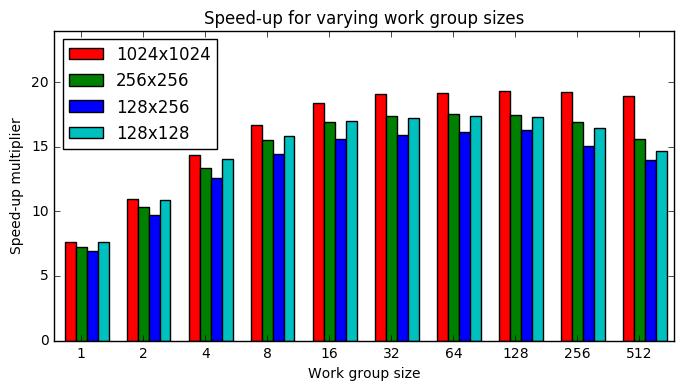

In [228]:
vary_work_group_sizes( './tests/test2/' )

In [39]:
def compare_tests( before, after, title, wgs = 128 ):
    dims = [ '1024x1024', '256x256', '128x256', '128x128' ]
    
    data = process_output_files( before )
    speedup_prior = runtime_to_speedup( data )
    ys_prior = [ dict(zip(*speedup_prior[k]))[ wgs ] for k in dims ]

    data = process_output_files( after )
    speedup_post = runtime_to_speedup( data )
    ys_post = sum( [ speedup_post[dim][1] for dim in dims ], [] )

    N = len( ys_post )
    ind = np.arange(N) + 0.15  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots( figsize = (8, 2) )

    colors = [ 'r', 'b' ]
    barGroups = []
    for i, ys in enumerate( [ ys_prior, ys_post ] ):
        rects = ax.bar( ind + (i+1)*width/2, ys, width/2, color=colors.pop(0) )
        barGroups.append( rects )
        for rect in rects:
            height = rect.get_height()
            ax.text( rect.get_x() + rect.get_width() / 2., 1.05 + height,
                     '%d' % int( height ),
                     ha='center', va='bottom' )

    # add some text for labels, title and axes ticks
    ax.set_ylabel( 'runtime (s)' )
    ax.set_title( 'Serial runtimes on starting codebase' )
    ax.set_xticks( ind + width )
    ax.set_xticklabels( dims )
    ax.set_ylim([ 0, 1.2 * max([ max( ys_prior ), max( ys_post ) ]) ])

    ax.legend( [ group[0] for group in barGroups ], ['Before', 'After'], loc = 0 )
    ax.set_title( title )
    ax.set_ylabel( 'Speed-up multiplier' )
    ax.set_xlabel( 'Grid dimensions')
    plt.show()
    

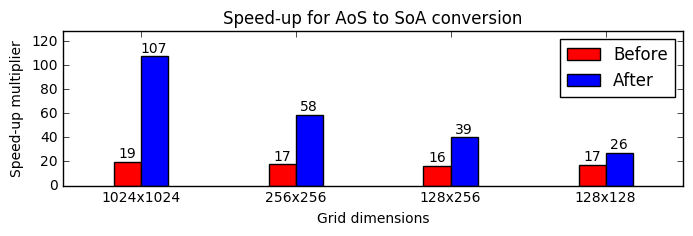

In [229]:
compare_tests( './tests/test2/', './tests/test3/', 'Speed-up for AoS to SoA conversion' )

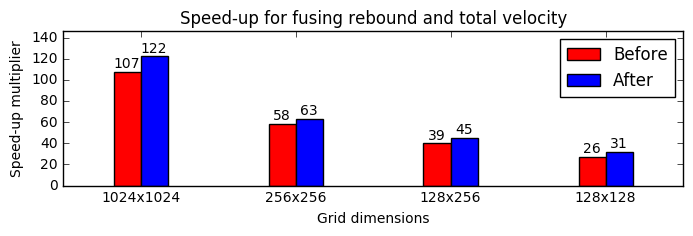

In [230]:
compare_tests( './tests/test3/', './tests/test4/', 'Speed-up for fusing rebound and total velocity' )

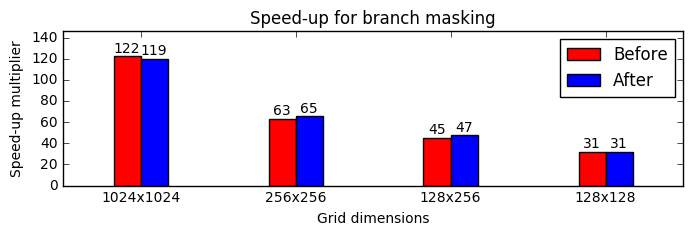

In [42]:
compare_tests( './tests/test4/', './tests/test5/', 'Speed-up for branch masking' )

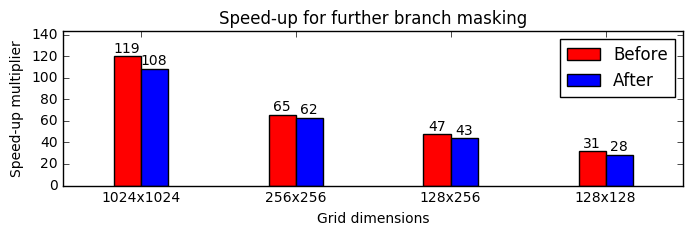

In [223]:
compare_tests( './tests/test5/', './tests/test11/', 'Speed-up for further branch masking' )

In [246]:
process_output_files( './tests/test5/' )

{'1024x1024': ([128], [29.02987]),
 '128x128': ([128], [3.315148]),
 '128x256': ([128], [4.49723]),
 '256x256': ([128], [13.030986])}

In [247]:
process_output_files( './tests/test11/' )

{'1024x1024': ([128], [32.052572]),
 '128x128': ([128], [3.693382]),
 '128x256': ([128], [4.885227]),
 '256x256': ([128], [13.582817])}

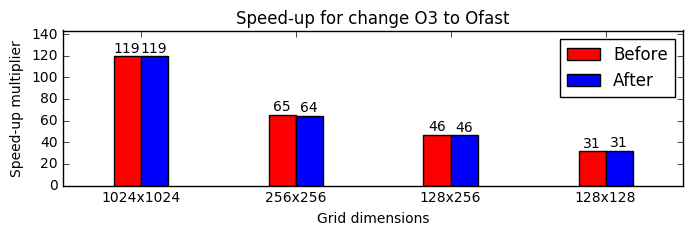

In [224]:
compare_tests( './tests/test12/', './tests/test14/', 'Speed-up for change O3 to Ofast' )

In [48]:
process_output_files( './tests/test5/' )

{'1024x1024': ([128], [29.02987]),
 '128x128': ([128], [3.315148]),
 '128x256': ([128], [4.49723]),
 '256x256': ([128], [13.030986])}

In [249]:
process_output_files( './tests/test4/' )

{'1024x1024': ([128], [28.430337]),
 '128x128': ([128], [3.296752]),
 '128x256': ([128], [4.732801]),
 '256x256': ([128], [13.570705])}

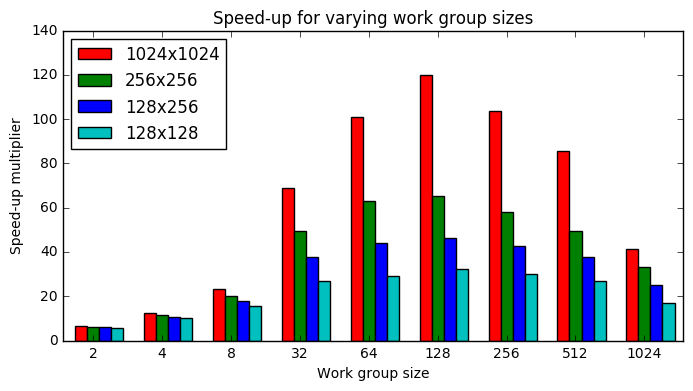

In [102]:
vary_work_group_sizes( './tests/test7/', ymax=140, legendLoc = 2 )

In [236]:
process_output_files( './tests/test19/' )

{'256x256': ([128, 128, 128, 128, 128, 128, 128, 128, 128],
  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
  [13.383309,
   13.47117,
   13.328391,
   13.482196,
   13.50407,
   13.410926,
   13.491104,
   13.458532,
   13.291507])}

In [237]:
process_output_files( './tests/test20/' )

{'256x256': ([128, 128, 128],
  [0.1, 0.5, 0.9],
  [14.920288, 14.967517, 14.643957])}

In [ ]:
[ 13.38, 13.50, 13.30 ]

In [ ]:
[ 14.92, 14.97, 14.64 ] 